# Level 1: Rice Crop Discovery Tool Benchmark Notebook

## Challenge Level 1 Overview

<p align="justify">Welcome to the EY Open Science Data Challenge 2023! This challenge consists of two levels – Level 1 and Level 2. This is the Level 1 challenge aimed at participants who are beginners or have intermediate skill sets in data science and programming. The goal of Level 1 is to predict the presence of rice crops at a given location using satellite data. By the time you complete this level, you will have developed a rice crop classification model, which can distinguish between rice and non-rice fields. 
</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been built to predict rice crops against non-rice crops (which might include forest, other vegetation and water bodies) using features from the Sentinel-1 Radiometrically Terrain Corrected (RTC)  dataset as predictor variables. In this demonstration, we have used two features from the Sentinel-1 dataset, namely VV (Vertical polarization – Vertical polarization) and VH (Vertical polarization – Horizontal polarization) and trained a logistic regression model with these features. We have extracted the VV band and VH band data from the Sentinel-1 dataset for one day (21st March 2020), with an assumption that VV and VH values for this day are representative of VV and VH values for the entire year (2020) for a given location.

Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook">Sentinel-1-RTC notebook</a> found in the Planetary Computer portal.</p>
    
<p align="justify"> Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

#### Note: Environment setup
Running this notebook requires an API key.

To use your API key locally, set the environment variable <i><b>PC_SDK_SUBSCRIPTION_KEY</i></b> or use <i><b>planetary_computer.settings.set_subscription_key(<YOUR API Key>)</i></b><br>
See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization

import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('b122cfe1eb0a4080b21ea3aec0542a09')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

## Response Variable

Before building the model, we need to load in the rice crop presence data. We have curated for you data from a certain region in Vietnam for the year 2022. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [2]:
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
crop_presence_data.head()


,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [3]:
crop_presence_data.groupby('Class of Land').head()
crop_presence_data["Latitude and Longitude"][0]

'(10.323727047081501, 105.2516346045924)'

In [4]:
# We have a balanced data set (50% Rice, 50% Non Rice)
crop_presence_data["Class of Land"].value_counts()['Rice']

300

## Predictor Variables

<p align ="justify">Now that we have our crop location data, it is time to gather the predictor variables from the Sentinel-1 dataset. For a more in-depth look regarding the Sentinel-1 dataset and how to query it, see the Sentinel-1 <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb/"> supplementary 
notebook</a>.
    

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Band values such as VV and VH help us in distinguishing between the rice and non rice crops. Hence we are choosing VV and VH as predictor variables for this experiment. 
        
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
</ul>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-1 data. For example, you can use mathematical combinations of bands to generate various <a href="https://challenge.ey.com/api/v1/storage/admin-files/3868217534768359-63ca8dc8aea56e00146e3489-Comprehensive%20Guide%20-%20Satellite%20Data.docx">vegetation indices </a> which can then be used as features in your model.


### My notes for some background info regarding technical terms and scientific concepts
What are some useful bands from teh sentinel 1 data that i can use in my prediction model to classify whether a given location coordinates would be suitable for planting rice or wheat?

Some useful bands from the Sentinel-1 data that can be used in a prediction model to classify whether a given location coordinates would be suitable for planting rice or wheat include the VV (vertical transmit/vertical receive) and VH (vertical transmit/horizontal receive) bands, as well as the normalized difference vegetation index (NDVI). Additionally, the backscattering coefficient (sigma0) can provide information about soil moisture levels, which can be used to determine if a given location is suitable for planting.

## Question: why is VV or VH band useful for predicting vegetation health

The VV and VH bands are useful for predicting vegetation health because they measure the backscattering of the radar signal from the ground. This backscattering is affected by the vegetation in the area, which allows the VV and VH bands to be used to assess the health of the vegetation. Specifically, the higher the backscattering, the healthier the vegetation. Additionally, the VV and VH bands can be combined to generate the normalized difference vegetation index (NDVI), which is a widely used index for determining the health of vegetation.
what is backscattering

## What is Backscattering

Backscattering is the reflection of a wave (such as a radar signal) off an object or surface. The intensity of the backscattered wave is affected by the properties of the object or surface, such as its composition, size, and shape. In the context of radar, backscattering is typically used to measure the reflectivity of the ground, which can be used to assess the health of vegetation in an area.

## so VV and VH bands are metrics to measure backscattering? 
Yes, the VV and VH bands are metrics to measure the backscattering of a radar signal from the ground. The higher the backscattering, the healthier the vegetation. Additionally, the VV and VH bands can be combined to generate the normalized difference vegetation index (NDVI), which is a widely used index for determining the health of vegetation.
so higher vv and vh values the more suitable for rice planting?

Higher VV and VH values can indicate the health of vegetation in an area, which can be an indicator of suitability for planting. However, other factors such as soil moisture levels, temperature, and nutrient availability should also be taken into account when determining suitability for planting.

## wjhy is it that the backscattering is low if the soil is not healthy?

The backscattering of a radar signal is affected by the composition, size, and shape of the object or surface it is reflecting off of. Soil that is not healthy, such as soil that is dry or compacted, will not reflect the radar signal as well, resulting in a lower backscattering coefficient.

## what is the backscattering coefficient?

The backscattering coefficient (sigma0) is a measure of the amount of energy that is reflected back from a surface when it is hit by a radar pulse. The backscattering coefficient is used to measure the reflectivity of the ground, which can be used to assess the health of vegetation in an area.
is that data different from VV or VH?

Yes, the backscattering coefficient (sigma0) is different from the VV and VH bands. The VV and VH bands measure the backscattering of the radar signal from the ground, whereas the sigma0 measures the amount of energy that is reflected back from a surface when it is hit by a radar pulse.


## how do i calculate the ratio using the VV and VH band values

The ratio of the VV and VH bands can be calculated by dividing the VV band value by the VH band value. For example, if the VV band value is 0.8 and the VH band value is 0.6, then the ratio would be 0.8/0.6 = 1.33. This ratio can then be used to calculate the backscattering coefficient (sigma0).

## the higher the better indication of healthy soil?

Yes, the higher the backscattering coefficient (sigma0), the better the indication of healthy soil. Generally, a higher sigma0 indicates more reflective surfaces and vegetation in the area, which can indicate healthier soil.

## Then in the sentinel 1 dataset what are useful data sets we can use for this project

The Sentinel-1 dataset contains multiple bands that can be used for this project, including the VV (vertical transmit/vertical receive) and VH (vertical transmit/horizontal receive) bands, as well as the normalized difference vegetation index (NDVI). Additionally, the backscattering coefficient (sigma0) can provide information about soil moisture levels, which can be used to determine if a given location is suitable for planting.

## so if the energy reflected is higher it means the plant or soil did not absorb?

Yes, a higher backscattering coefficient (sigma0) indicates that the energy reflected back from the surface was not absorbed by the plant or soil. This can be used to assess the health of vegetation in an area.

## why is less absorption of energy mean healthy vegetation?

Less absorption of energy by the vegetation or soil indicates that the surface is reflective, which means that the vegetation is healthy. Healthy vegetation typically has a higher reflectivity, as it is able to absorb more energy from the sun, which is reflected back into the atmosphere.

### Useful Predicitive Variables to consider using in model: 

1. VV and VH bands to measure backscattering means healthy soil
2. NDVI assess health of vegetaion in an area
3. Backscattering coefficient or sigma measures amount of energy that is reflected back from a surface when hit on a radar pulse

### About the Data

### Accessing the Sentinel-1 Data

<p align = "Justify">To get the Sentinel-1 data, we write a function called <i><b>get_sentinel_data.</b></i> This function will fetch VV and VH band values for a particular location over the specified time window. In this example, we have extracted VV and VH values for a day (21st March 2020). </p> 
#change this to multiple time period

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 2</strong></h4>
<p align="justify"> Extract VV and VH band values for an entire year. Different land classes (e.g., agriculture, water, urban) will have different annual variability. This variability will be better than a single date for accurately identifying land classes. Please find below a demonstration of extracting data for a day (21st March 2020).

In [8]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''
    square_val = 0.00025

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox_of_interest = (float(latlong[1])-square_val , float(latlong[0])-square_val, float(latlong[1])+square_val , float(latlong[0])+square_val)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        'https://planetarycomputer.microsoft.com/api/stac/v1'
        
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assests
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    vh = data["vh"].astype("float").values.tolist()[0][0]
    vv = data["vv"].astype("float").values.tolist()[0][0]
    return vh,vv

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 3 </strong></h4>

Explore the approach of building a bounding box (e.g., 5x5 pixels) around the given latitude and longitude positions and then extract the aggregated band values (e.g., average, median) to get normalized band values to build the model. Radar data has inherent variability at the pixel level due to variable scattering response from the target. This effect is called “speckle” and it is common to filter the data to smooth these variations. Try using a 3x3, 5x5 or 7x7 window around the specific latitude and longitude point to get improved results.

In [9]:
import dateutil.parser

In [10]:

## Function call to extract VV,VH Values


time_slice = "2020-02-20/2020-03-21"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|█████████████████████████████████████████| 600/600 [07:24<00:00,  1.35it/s]


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [5]:
def get_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''
    square_val = 0.00025

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox_of_interest = (float(latlong[1])-square_val , float(latlong[0])-square_val, float(latlong[1])+square_val , float(latlong[0])+square_val)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        'https://planetarycomputer.microsoft.com/api/stac/v1'
        
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assests
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    return data

In [6]:
n = 1

time_slice = "2020-02-20/2020-03-21"
assests = ['vh','vv']
vh_vv_rvi = []

for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    data = get_data(coordinates,time_slice,assests)
    mean = data.mean().compute()
    dop = (mean.vv / (mean.vv + mean.vh))
    m = 1 - dop
    rvi = (np.sqrt(dop))*((4*mean.vh)/(mean.vv + mean.vh))
    vh_vv_rvi.append([mean.vv.values, mean.vh.values, rvi.values])
vh_vv_rvi_data = pd.DataFrame(vh_vv_rvi,columns =['vh','vv', 'rvi'])

100%|█████████████████████████████████████████| 600/600 [07:08<00:00,  1.40it/s]


In [8]:
vh_vv_rvi_data

,vh,vv,rvi
0,0.20758393,0.06232412,0.8100078204238705
1,0.15551779,0.03757794,0.6985925867387248
2,0.21735105,0.04275458,0.6010337436495468
3,0.16330516,0.03154174,0.5927960744431653
4,0.2314578,0.03876194,0.5310382211650145
...,...,...,...
595,0.19289711,0.050605137,0.7398829233646299
596,0.26415795,0.054577384,0.6235327090934485
597,0.32137352,0.067015804,0.6278289731235115
598,0.2864713,0.071513124,0.7148091780346641


In [8]:
type(data)

xarray.core.dataset.Dataset

In [9]:
data.to_dataframe()

spatial_ref                       time        vh        vv
y         x                                                                   
1141245.0 527525.0        32648 2020-03-21 11:11:40.411220  0.041119  0.251806
          527535.0        32648 2020-03-21 11:11:40.411220  0.046050  0.367144
          527545.0        32648 2020-03-21 11:11:40.411220  0.050608  0.323299
          527555.0        32648 2020-03-21 11:11:40.411220  0.069238  0.203891
          527565.0        32648 2020-03-21 11:11:40.411220  0.085067  0.148480
          527575.0        32648 2020-03-21 11:11:40.411220  0.092893  0.173268
1141235.0 527525.0        32648 2020-03-21 11:11:40.411220  0.043877  0.127348
          527535.0        32648 2020-03-21 11:11:40.411220  0.053948  0.219720
          527545.0        32648 2020-03-21 11:11:40.411220  0.046663  0.211819
          527555.0        32648 2020-03-21 11:11:40.411220  0.062405  0.135082
          527565.0        32648 2020-03-21 11:11:40.411220  0.065699  0.108546
          527575.0        32648 2020-03-21 11:11:40.411220  0.066923  0.245254
1141225.0 527525.0        32648 2020-03-21 11:11:40.411220  0.025806  0.179919
          527535.0        32648 2020-03-21 11:11:40.411220  0.043007  0.266566
          527545.0        32648 2020-03-21 11:11:40.411220  0.056330  0.228188
          527555.0        32648 2020-03-21 11:11:40.411220  0.066411  0.135568
          527565.0        32648 2020-03-21 11:11:40.411220  0.057439  0.117132
          527575.0        32648 2020-03-21 11:11:40.411220  0.065794  0.233281
1141215.0 527525.0        32648 2020-03-21 11:11:40.411220  0.024852  0.176314
          527535.0        32648 2020-03-21 11:11:40.411220  0.036740  0.198917
          527545.0        32648 2020-03-21 11:11:40.411220  0.055557  0.161107
          527555.0        32648 2020-03-21 11:11:40.411220  0.065339  0.137559
          527565.0        32648 2020-03-21 11:11:40.411220  0.058402  0.147661
          527575.0        32648 2020-03-21 11:11:40.411220  0.058349  0.176253
1141205.0 527525.0        32648 2020-03-21 11:11:40.411220  0.032149  0.138529
          527535.0        32648 2020-03-21 11:11:40.411220  0.038500  0.120950
          527545.0        32648 2020-03-21 11:11:40.411220  0.041293  0.114049
          527555.0        32648 2020-03-21 11:11:40.411220  0.059691  0.176895
          527565.0        32648 2020-03-21 11:11:40.411220  0.080693  0.220665
          527575.0        32648 2020-03-21 11:11:40.411220  0.057985  0.247091
1141195.0 527525.0        32648 2020-03-21 11:11:40.411220  0.024517  0.130036
          527535.0        32648 2020-03-21 11:11:40.411220  0.026459  0.202118
          527545.0        32648 2020-03-21 11:11:40.411220  0.028247  0.226293
          527555.0        32648 2020-03-21 11:11:40.411220  0.069687  0.232291
          527565.0        32648 2020-03-21 11:11:40.411220  0.152509  0.274492
          527575.0        32648 2020-03-21 11:11:40.411220  0.107476  0.356364
1141185.0 527525.0        32648 2020-03-21 11:11:40.411220  0.019553  0.161752
          527535.0        32648 2020-03-21 11:11:40.411220  0.017543  0.285918
          527545.0        32648 2020-03-21 11:11:40.411220  0.026878  0.292075
          527555.0        32648 2020-03-21 11:11:40.411220  0.111593  0.234986
          527565.0        32648 2020-03-21 11:11:40.411220  0.224140  0.287953
          527575.0        32648 2020-03-21 11:11:40.411220  0.160185  0.341944

In [27]:
vh_vv_data.to_csv('pred_data.csv', index=False)

In [13]:
vh_vv_data.shape

(600, 2)

In [28]:
vh_vv_data

,vh,vv
0,0.051305,0.507141
1,0.025675,0.210904
2,0.017782,0.288333
3,0.045639,0.325562
4,0.019222,0.191109
...,...,...
595,0.093325,0.114293
596,0.038517,0.180069
597,0.056709,0.254847
598,0.072502,0.110558


In [29]:
vh_vv_data = pd.read_csv("data/pred_data.csv")
vh_vv_data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/pred_data.csv'

In [10]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically con"catenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [20]:
crop_data = combine_two_datasets(crop_presence_data,vh_vv_rvi_data)
crop_data['Class of Land'].value_counts()

Rice        300
Non Rice    300
Name: Class of Land, dtype: int64

In [32]:
# Calculate RVI(vv/vv+vh)
dop = (crop_data["vv"] / (crop_data["vv"] + crop_data["vh"]))
m = 1 - dop
rvi = (np.sqrt(dop))*((4*crop_data["vh"])/(crop_data["vv"] + crop_data["vh"]))
crop_data["rvi"] = rvi


## Model Building


In [21]:
crop_data.head()

,Latitude and Longitude,Class of Land,vh,vv,rvi
0,"(10.323727047081501, 105.2516346045924)",Rice,0.20758393,0.06232412,0.8100078204238705
1,"(10.322364360592521, 105.27843410554115)",Rice,0.15551779,0.03757794,0.6985925867387248
2,"(10.321455902933202, 105.25254306225168)",Rice,0.21735105,0.04275458,0.6010337436495468
3,"(10.324181275911162, 105.25118037576274)",Rice,0.16330516,0.03154174,0.5927960744431653
4,"(10.324635504740822, 105.27389181724476)",Rice,0.2314578,0.03876194,0.5310382211650145


In [34]:
crop_data

,Latitude and Longitude,Class of Land,vh,vv,rvi
0,"(10.323727047081501, 105.2516346045924)",Rice,0.051305,0.507141,0.350196
1,"(10.322364360592521, 105.27843410554115)",Rice,0.025675,0.210904,0.409873
2,"(10.321455902933202, 105.25254306225168)",Rice,0.017782,0.288333,0.225513
3,"(10.324181275911162, 105.25118037576274)",Rice,0.045639,0.325562,0.460574
4,"(10.324635504740822, 105.27389181724476)",Rice,0.019222,0.191109,0.348457
...,...,...,...,...,...
595,"(10.013942985253381, 105.67361318732796)",Non Rice,0.093325,0.114293,1.334044
596,"(10.01348875642372, 105.67361318732796)",Non Rice,0.038517,0.180069,0.639737
597,"(10.013034527594062, 105.67361318732796)",Non Rice,0.056709,0.254847,0.658485
598,"(10.012580298764401, 105.67361318732796)",Non Rice,0.072502,0.110558,1.231162


<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only VV and VH, rvi for our model. It does not make sense to use latitude and longitude as predictor variables as they do not have any impact on presence of rice crop.</p>

In [35]:
crop_data = crop_data[['vh','vv','Class of Land']]

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [36]:
crop_data

,vh,vv,Class of Land
0,0.051305,0.507141,Rice
1,0.025675,0.210904,Rice
2,0.017782,0.288333,Rice
3,0.045639,0.325562,Rice
4,0.019222,0.191109,Rice
...,...,...,...
595,0.093325,0.114293,Non Rice
596,0.038517,0.180069,Non Rice
597,0.056709,0.254847,Non Rice
598,0.072502,0.110558,Non Rice


In [37]:
crop_data['Class of Land'] = crop_data['Class of Land'].replace({'Rice': 1, 'Non Rice': 0})

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.datasets import make_blobs
from sklearn import set_config
set_config('display')

In [39]:
#classification by using K-Nearest Neighbors algorithm


In [47]:
#Calculate sigma_nought

# Convert dB to linear scale
crop_data['vh_lin'] = 10**(crop_data['vh'] / 10)
crop_data['vv_lin'] = 10**(crop_data['vv'] / 10)

# Calculate Sigma-nought

crop_data['sigma0_temp'] = (crop_data['vv_lin']**2 + crop_data['vh_lin']**2) / 2




crop_data['sigma0_temp1'] = crop_data['sigma0_temp'].apply(lambda x: np.log10(x))
crop_data['sigma0'] = 10 * crop_data['sigma0_temp1']

# Calculate Gamma-nought
crop_data['gamma0'] = 10**(0.1*(crop_data['vh'] + crop_data['vv']))

In [51]:
crop_data

submission_df.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)

,Latitude and Longitude,Class of Land,vh,vv,rvi,vh_lin,vv_lin,gamma0,sigma0_temp,sigma0_temp1,sigma0
0,"(10.323727047081501, 105.2516346045924)",Rice,0.20758393,0.06232412,0.8100078204238705,1.048959,1.014454,1.06412,1.064716,0.027234,0.272337
1,"(10.322364360592521, 105.27843410554115)",Rice,0.15551779,0.03757794,0.6985925867387248,1.036458,1.00869,1.045465,1.045851,0.019470,0.194697
2,"(10.321455902933202, 105.25254306225168)",Rice,0.21735105,0.04275458,0.6010337436495468,1.05132,1.009893,1.061721,1.062579,0.026361,0.263614
3,"(10.324181275911162, 105.25118037576274)",Rice,0.16330516,0.03154174,0.5927960744431653,1.038318,1.007289,1.045887,1.046368,0.019685,0.196845
4,"(10.324635504740822, 105.27389181724476)",Rice,0.2314578,0.03876194,0.5310382211650145,1.054741,1.008965,1.064197,1.065245,0.027449,0.274493
...,...,...,...,...,...,...,...,...,...,...,...
595,"(10.013942985253381, 105.67361318732796)",Non Rice,0.19289711,0.050605137,0.7398829233646299,1.045417,1.01172,1.05767,1.058238,0.024583,0.245833
596,"(10.01348875642372, 105.67361318732796)",Non Rice,0.26415795,0.054577384,0.6235327090934485,1.062713,1.012646,1.076152,1.077405,0.032379,0.323790
597,"(10.013034527594062, 105.67361318732796)",Non Rice,0.32137352,0.067015804,0.6278289731235115,1.076806,1.015551,1.093551,1.095427,0.039583,0.395834
598,"(10.012580298764401, 105.67361318732796)",Non Rice,0.2864713,0.071513124,0.7148091780346641,1.068187,1.016603,1.085922,1.087252,0.036330,0.363302


In [72]:
X = crop_data.drop(columns=['Class of Land', 'Latitude and Longitude','vv_lin', 'vh_lin', 'sigma0_temp', 'sigma0_temp1', 'sigma0', 'gamma0' ]).values
y = crop_data ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

#'vv_lin', 'vh_lin', 'sigma0_temp', 'sigma0_temp1'

### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of VV and VH and RVI variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler.</p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 4 </strong></h4>
<p align="justify">Participants might explore other feature scaling techniques like Min Max Scaler, Max Absolute Scaling, Robust Scaling etc.</p>

In [73]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p justify ="align">Now that we have the data in a format appropriate for machine learning, we can begin training a model. In this demonstration notebook, we have used a binary logistic regression model from the scikit-learn library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</p>

<p justify ="align">Scikit-learn models require separation of predictor variables and the response variable. You have to store the predictor variables in array X and the response variable in the array Y. You must make sure not to include the response variable in array X. It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.</p>

In [81]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)
accuracy = model.score(X_test, y_test)
accuracy

0.7777777777777778

In [127]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
#ensemble (use multiple models knn, logistic, and decision trees)
from sklearn.ensemble import VotingClassifier
model = VotingClassifier([('knn', KNeighborsClassifier(n_neighbors=3)),
                          ('logistic', LogisticRegression(max_iter=500)),
                        ('tree', DecisionTreeClassifier(max_depth = 3)),
                          ('svm', svm.SVC(kernel='rbf', C = 100000, gamma=0.0034))
                          ])
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
accuracy

0.7888888888888889

In [128]:
from sklearn import svm
model = svm.SVC(kernel='rbf', C = 100000, gamma=0.0025)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
accuracy

0.8222222222222222

In [132]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
model = RandomForestClassifier(n_estimators=100, max_depth=5)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
accuracy

0.7833333333333333

## Model Evaluation

Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the classification report and will plot the confusion matrix. Scikit-learn provides many other metrics that can be used for evaluation. You can even write a code on your own.

### In-Sample Evaluation
<p align="Jutisfy"> We will be generating a classification report and a confusion matrix for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance. You should wait to test the model performance on the test data before you feel confident about your model.</p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [112]:
insample_predictions = model.predict(X_train)

In [116]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 81.19%
              precision    recall  f1-score   support

    Non Rice       0.83      0.80      0.82       219
        Rice       0.79      0.83      0.81       201

    accuracy                           0.81       420
   macro avg       0.81      0.81      0.81       420
weighted avg       0.81      0.81      0.81       420



<p> For plotting a confusion matrix we define the function <b><i>plot_confusion_matrix</i></b>.

In [67]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

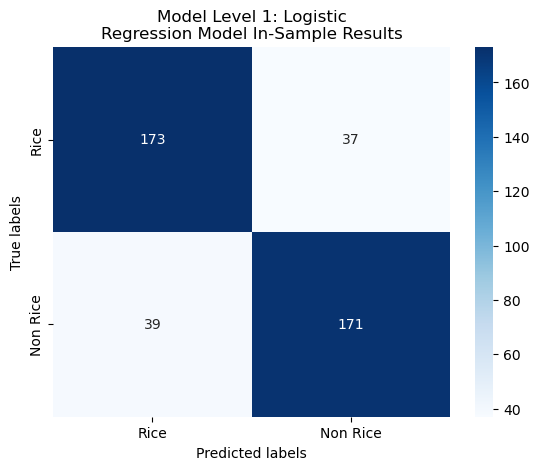

In [46]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

In [47]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=500)

In [48]:
clf.fit(X_train,y_train)
insample_predictions2 = clf.predict(X_train)

In [49]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions2,y_train)))
print(classification_report(insample_predictions2,y_train))

Insample Accuracy 57.38%
              precision    recall  f1-score   support

           0       0.51      0.58      0.55       185
           1       0.63      0.57      0.60       235

    accuracy                           0.57       420
   macro avg       0.57      0.57      0.57       420
weighted avg       0.58      0.57      0.58       420



In [50]:
#decision tree classifier (basic)
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
max_depth_values = range(1, 11)
cv_scores = []
for max_depth in max_depth_values:
    clf.set_params(max_depth=max_depth)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    cv_scores.append(np.mean(scores))

for max_depth, score in zip(max_depth_values, cv_scores):
    print(f"max_depth = {max_depth}: Mean CV score = {score:.3f}")


max_depth = 1: Mean CV score = 0.624
max_depth = 2: Mean CV score = 0.655
max_depth = 3: Mean CV score = 0.679
max_depth = 4: Mean CV score = 0.698
max_depth = 5: Mean CV score = 0.674
max_depth = 6: Mean CV score = 0.671
max_depth = 7: Mean CV score = 0.688
max_depth = 8: Mean CV score = 0.650
max_depth = 9: Mean CV score = 0.674
max_depth = 10: Mean CV score = 0.667


In [51]:
clf = DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(X_train,y_train)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3)

In [52]:
insample_predictions3 = clf.predict(X_train)

In [53]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions3,y_train)))
print(classification_report(insample_predictions3,y_train))

Insample Accuracy 72.86%
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       186
           1       0.79      0.71      0.74       234

    accuracy                           0.73       420
   macro avg       0.73      0.73      0.73       420
weighted avg       0.74      0.73      0.73       420



In [54]:
outsample_predictions3 = clf.predict(X_test)
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions3, y_test)))
print(classification_report(y_test, outsample_predictions3))

Accuracy 66.67%
              precision    recall  f1-score   support

           0       0.72      0.54      0.62        90
           1       0.63      0.79      0.70        90

    accuracy                           0.67       180
   macro avg       0.68      0.67      0.66       180
weighted avg       0.68      0.67      0.66       180



In [50]:
#ensemble (use multiple models knn, logistic, and decision trees)
from sklearn.ensemble import VotingClassifier
voter = VotingClassifier([('knn', KNeighborsClassifier(n_neighbors=3)),
                          ('logistic', LogisticRegression(max_iter=500)),
                          ('tree', DecisionTreeClassifier(max_depth = 3)),
                          ])
voter.fit(X_train, y_train)
accuracy = voter.score(X_test, y_test)
accuracy


0.8055555555555556

In [56]:
outsample_predictions4 = voter.predict(X_test)
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions4, y_test)))
print(classification_report(y_test, outsample_predictions4))

Accuracy 66.67%
              precision    recall  f1-score   support

           0       0.70      0.59      0.64        90
           1       0.64      0.74      0.69        90

    accuracy                           0.67       180
   macro avg       0.67      0.67      0.66       180
weighted avg       0.67      0.67      0.66       180



In [57]:
#import random forest
from sklearn.ensemble import RandomForestClassifier
#pipeline
forest = RandomForestClassifier(max_depth = 3)
forest.fit(X_train, y_train)
insample_predictions5 = forest.predict(X_train)

In [58]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions5,y_train)))
print(classification_report(insample_predictions5,y_train))

Insample Accuracy 75.24%
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       216
           1       0.74      0.76      0.75       204

    accuracy                           0.75       420
   macro avg       0.75      0.75      0.75       420
weighted avg       0.75      0.75      0.75       420



In [59]:
outsample_predictions5 = forest.predict(X_test)
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions5, y_test)))
print(classification_report(y_test, outsample_predictions5))

Accuracy 66.67%
              precision    recall  f1-score   support

           0       0.70      0.58      0.63        90
           1       0.64      0.76      0.69        90

    accuracy                           0.67       180
   macro avg       0.67      0.67      0.66       180
weighted avg       0.67      0.67      0.66       180



In [63]:
!pip install xgboost
#xgboost
import xgboost as xgb
#instantiate classifier 
xboost = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)
xboost.fit(X_train, y_train)
insample_predictions6 = xboost.predict(X_train)

In [64]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions6,y_train)))
print(classification_report(insample_predictions6,y_train))

Insample Accuracy 76.19%
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       226
           1       0.72      0.78      0.75       194

    accuracy                           0.76       420
   macro avg       0.76      0.76      0.76       420
weighted avg       0.76      0.76      0.76       420



In [65]:
outsample_predictions6 = xboost.predict(X_test)
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions6, y_test)))
print(classification_report(y_test, outsample_predictions5))

Accuracy 63.33%
              precision    recall  f1-score   support

           0       0.70      0.58      0.63        90
           1       0.64      0.76      0.69        90

    accuracy                           0.67       180
   macro avg       0.67      0.67      0.66       180
weighted avg       0.67      0.67      0.66       180



### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [68]:
outsample_predictions = model.predict(X_test)

In [69]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 78.89%
              precision    recall  f1-score   support

    Non Rice       0.74      0.89      0.81        90
        Rice       0.86      0.69      0.77        90

    accuracy                           0.79       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.79      0.79       180



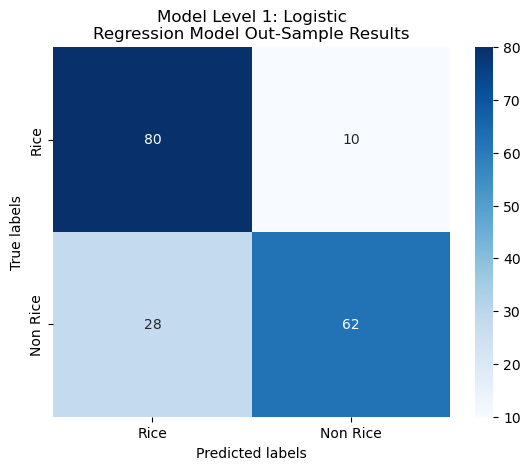

In [70]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

From the above, we see that the model is able to achieve an F1 score of <b>0.57</b>. This is not a very good score, so your goal is to improve this score.  

In [69]:
#Using Cross-Validation to find optimal K
k_values = [i for i in range (1,31)]
scores = []
scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

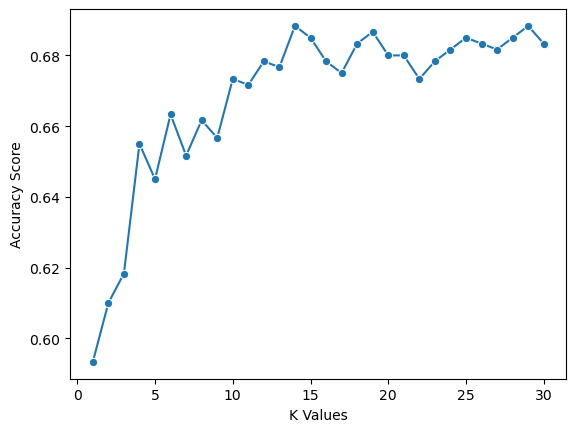

In [70]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

## Submission

Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make predictions about the presence of rice crops for a set of test coordinates we have provided in the <a href="https://challenge.ey.com/api/v1/storage/admin-files/6847912254281276-63ca8b5ab12e510013520e2b-challenge_1_submission_template.csv"><b>"challenge_1_submission_template.csv"</b></a> file and upload the file onto the challenge platform.

In [71]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_file.head()

,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [72]:
## Get Sentinel-1-RTC Data
time_slice = "2020-03-20/2020-03-21"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(test_file['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
submission_vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

KeyError: 'Latitude and Longitude'

In [73]:
submission_vh_vv_data.head()

NameError: name 'submission_vh_vv_data' is not defined

In [74]:
# Feature Scaling 
submission_vh_vv_data = submission_vh_vv_data.values
transformed_submission_data = sc.transform(submission_vh_vv_data)

NameError: name 'submission_vh_vv_data' is not defined

In [75]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

NameError: name 'transformed_submission_data' is not defined

In [76]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Latitude and Longitude':test_file['Latitude and Longitude'].values, 'Class of Land':final_prediction_series.values})

KeyError: 'Latitude and Longitude'

In [77]:
#Displaying the sample submission dataframe
display(submission_df)

NameError: name 'submission_df' is not defined

In [78]:
#Dumping the predictions into a csv file.
submission_df.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)

NameError: name 'submission_df' is not defined

## Conclusion

Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!